# Eric Report Usage

***Note to use this notebook Python, Jupyter Notebook, pandas and mathplotlib are required. Jump server 140 has all these.***

### Notebook Config
- Import pandas
- Tweak for graph display

In [1]:
import pandas as pd
%matplotlib inline

### Sourcing The Data

Grab some report usage data from Eric database and export to tsv file, **eric_report_use.tsv**
```
select *  from report_usage 
where date_requested between '21-JAN-2016' and '31-JAN-2016'
order by date_requested, hour_requested
```
*Note with right Oracle Instant Client setup we should be able to run the query directly from this notebook instead*

**Read data into a pandas dataframe**

In [2]:
csv_file = "eric_report_use.tsv"
eric_data = pd.read_csv(csv_file, sep='\t', skiprows=0)

### Experiment - extract results for just one report type

In [3]:
# Extract rows with report_id ==1
# Also just keep three columns
report1_data = eric_data.loc[eric_data['REPORT_ID'] == 1, ["DATE_REQUESTED", "HOUR_REQUESTED", "NO_OF_REQUESTS"]]


In [4]:
#Lets get rid of by-hour results - can use groupby method
report1_daily = report1_data.groupby("DATE_REQUESTED").sum().NO_OF_REQUESTS


display(report1_daily)

DATE_REQUESTED
21/01/2016    19
22/01/2016     8
23/01/2016     4
25/01/2016    21
26/01/2016    21
27/01/2016    14
28/01/2016     6
29/01/2016    14
30/01/2016     1
Name: NO_OF_REQUESTS, dtype: int64

#### The above worked - let's make a function to do the same with any report

In [5]:
def daily(df, report_id=1):
    """Extact results for single report from report_usage dataframe"""
    report_data = df.loc[df['REPORT_ID'] == report_id, ["DATE_REQUESTED", "HOUR_REQUESTED", "NO_OF_REQUESTS"]]
    report_daily = report_data.groupby("DATE_REQUESTED").sum().NO_OF_REQUESTS
    return report_daily

#### Get daily figures for each report

In [6]:
# Find the reports actually present in the data
reports_present = eric_data["REPORT_ID"].unique()
reports_present.sort()

In [7]:
# Store the figures in dictionary
daily_figures = {}
for report_id in reports_present:
    temp = daily(eric_data, report_id)
    daily_figures["Report_"+str(report_id)] = temp

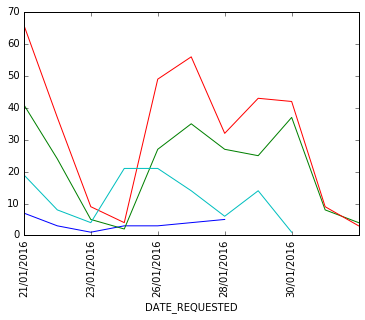

In [8]:
# Plot the results rot=90 sets x-axis text angle
for k, v in daily_figures.iteritems():
    v.plot(rot=90)

Above bad as 0 values excluded, so results misleading

# Idea

Reports above not great because data doesn't include any zero values for days/times when no reports requested. Also would be more convenient if the counts for each report are recorded in separate columns.

Reorganise the data in the new frame so that:

1. We have counts for each report in separate columns rather than relying on report_id: REPORT_1_COUNT, REPORT_2_COUNT ...
2. We have records of all the zero counts, i.e. we have rows for each hour of each day regardless of whether any report requests took place

Need to do some filtering by report ID

### Create empty dataframe for whole date rage with initial 0 counts

In [9]:
# handy - generates dates for each day from specified start to end
##dates =  pd.date_range("2016/1/1", "2016/1/31")

# Get first a last dates from the data - nb need iloc to get row by position
first_date = eric_data["DATE_REQUESTED"].iloc[0]
last_date = eric_data["DATE_REQUESTED"].iloc[-1]

# Getting it to use dates extracted from the data - need to do format conversion for this
fd = pd.to_datetime(first_date, dayfirst=True)
ld = pd.to_datetime(last_date, dayfirst=True)
dates = pd.date_range(fd, ld)

# Create dataframe with these dates 
df = pd.DataFrame({"Date":dates})
# Convert date format back to d/m/y in the fram
df['Date'] = df['Date'].dt.strftime('%d/%m/%Y')
rowcount = len(df)

#Set date to be the index
df.set_index('Date', inplace=True)

In [10]:
# Add columns to hold counts for each report type
for i in (0, 1, 2, 3, 4, 5):
    df["Report_"+str(i+1)] = [0]*rowcount
    

Check empty frame looks OK (just first few rows)

In [11]:
df.head()

,Report_1,Report_2,Report_3,Report_4,Report_5,Report_6
Date,,,,,,
21/01/2016,0,0,0,0,0,0
22/01/2016,0,0,0,0,0,0
23/01/2016,0,0,0,0,0,0
24/01/2016,0,0,0,0,0,0
25/01/2016,0,0,0,0,0,0


Now want to merge the extracted daily figures into the right places in the above

In [12]:
# Dodgy - items in daily_figres won't align to headings unless all present in the daily figures - need to change
for k, v in daily_figures.iteritems():
    df[k] = v
    

,Report_1,Report_2,Report_3,Report_4,Report_5,Report_6
Date,,,,,,
21/01/2016,19,66,41,0,0,7
22/01/2016,8,37,24,0,0,3
23/01/2016,4,9,5,0,0,1
24/01/2016,NaN,4,2,0,0,NaN
25/01/2016,21,49,27,0,0,NaN
26/01/2016,21,56,35,0,0,3
27/01/2016,14,32,27,0,0,3
28/01/2016,6,43,25,0,0,4
29/01/2016,14,42,37,0,0,5
